# Vertically Integrated Moisture Flux Convergence

This script illustrates calculating vertically integrated moisture flux convergence (MFC) for a dataset with a constant pressure level system.

To calculate this, we must first leverage [`geocat.comp.meteorology.delta_pressure`](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.meteorology.delta_pressure.html) for the vertical integration, and then [`geocat.comp.gradient.gradient`](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.gradient.gradient.html#geocat.comp.gradient.gradient) to get our gradients on the surface of the WGS84 ellipsoid.

In [19]:
import xarray as xr
import numpy as np
import geocat.comp as gc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create Data

Here we create a dummy Xarray Dataset with 2d zonal and meridional wind componenets, 3d water vapor, a 2d surface pressure array, and a 1d pressure level system.

In [3]:
x = np.linspace(-99, -84, 10)
y = np.linspace(40, 46, 8)

lon, lat = np.meshgrid(x, y)

pressure_lev = [10, 20, 30, 50, 70, 100, 150, 200, 300, 400, 500, 700, 1000]

u_wind = 5 + 20 * np.random.randn(*lon.shape)
v_wind = 5 * np.random.randn(*lon.shape)
q_vapor = 10 * np.random.randn(*lon.shape, len(pressure_lev))

surface_pressure = 1001 + 10 * np.random.randn(*lon.shape)

In [4]:
ds = xr.Dataset(
    data_vars=dict(
        u_wind = (["x", "y"], u_wind),
        v_wind = (["x", "y"], v_wind),
        q_vapor = (["x", "y", "lev"], q_vapor),
        surface_pressure = (["x", "y"], surface_pressure)
    ),
    coords=dict(
        lon=(["x", "y"], lon),
        lat=(["x", "y"], lat),
        pressure_lev=(["lev"], pressure_lev)
    )
)

ds.u_wind.attrs["units"] = "m s-1"
ds.v_wind.attrs["units"]= "m s-1"
ds.q_vapor.attrs["units"]= "g kg-1"
ds.surface_pressure["units"] = "Pa"
ds.pressure_lev["units"] = "Pa"
ds.lat["units"] = "degrees"
ds.lon["units"] = "degrees"

ds

<xarray.Dataset>
Dimensions:           (x: 8, y: 10, lev: 13)
Coordinates:
    lon               (x, y) float64 -99.0 -97.33 -95.67 ... -87.33 -85.67 -84.0
    lat               (x, y) float64 40.0 40.0 40.0 40.0 ... 46.0 46.0 46.0 46.0
    pressure_lev      (lev) int64 10 20 30 50 70 100 ... 300 400 500 700 1000
Dimensions without coordinates: x, y, lev
Data variables:
    u_wind            (x, y) float64 26.27 -20.22 22.23 ... -32.02 33.84 12.57
    v_wind            (x, y) float64 -4.646 -7.334 8.612 ... 9.598 1.567 -5.157
    q_vapor           (x, y, lev) float64 -15.81 19.58 3.893 ... 11.02 2.505
    surface_pressure  (x, y) float64 1.019e+03 1.01e+03 ... 997.1 1.014e+03

#  Vertical Integration

To do a mass-weighted vertical integration of our 3d water vapor, we need to first get a layer mass weighting. This is our delta pressure levels, divide by the gravitational constant. Then, multiply the layer mass weighting by the water vapor variable, and integrate vertially. 

In [5]:
delta_pressure_levels = gc.meteorology.delta_pressure(pressure_lev=ds.pressure_lev, surface_pressure=ds.surface_pressure)

g = 9.80665 # gravitational acceleration (m s-2)
layer_mass_weighting = delta_pressure_levels / g # Layer Mass Weighting
layer_mass_weighting .attrs["units"] = "kg m-2"

mass_weighted_vapor = ds.q_vapor * layer_mass_weighting # mass weighted 'q'
iq = mass_weighted_vapor.sum(dim="lev") # Vertically Integrated Vapor
iq.attrs["units"] = "g m-2"

# Calculate Moisture Flux Convergence (MFC)

The formula for MFC is as follows:

$MFC =  -u*\frac{dq}{dx} - v*\frac{dq}{dy} - q(\frac{du}{dx} + \frac{dv}{dy})$

where u represents the zonal wind component, v is the meridional wind componenet, and q is the moisture content (in our case, vertically integrated).

The first two terms of this equation, $-u*\frac{dq}{dx} - v*\frac{dq}{dy}$, are together the advection term, and the last term, $q(\frac{du}{dx} + \frac{dv}{dy})$, is our convergence term, with moisture flux convergence being the advection minus the convergence.

[Source: Banacos and Schultz, "Moisture Flux Convergence", NOAA 2004](https://www.spc.noaa.gov/publications/banacos/mfc-sls.pdf)

To do this calculation, we first need the gradients of our wind components and moisture. We are using Geocat-comp's [`gradient`](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.gradient.gradient.html#geocat.comp.gradient.gradient) method because of its improved accuracy for geospatial data over an Earth-like ellipsoid.

In [6]:
du_dx, du_dy = gc.gradient(ds.u_wind) # (s-1)
dv_dx, dv_dy = gc.gradient(ds.v_wind)
dq_dx, dq_dy = gc.gradient(iq) # (g m-3)

In [7]:
advection = (-u_wind * dq_dx) - (v_wind * dq_dy) # (g s-1 m-2)
convergence = iq * np.add(du_dx, dv_dy) # (g s-1 m-2)

mfc = advection - convergence # moisture flux convergence (g m-2 s-1)

## Plot Data

And finally we can view our moisture flux convergence.

/Users/jkent/miniconda3/envs/gc-docs/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jkent/miniconda3/envs/gc-docs/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


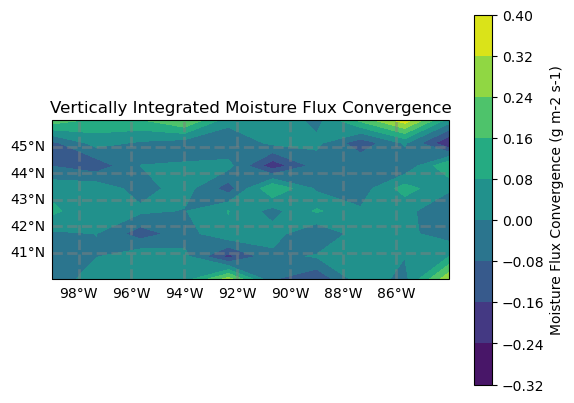

In [26]:
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lon, lat, mfc, transform=ccrs.PlateCarree())
plt.title('Vertically Integrated Moisture Flux Convergence')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

cbar = plt.colorbar()
cbar.set_label('Moisture Flux Convergence (g m-2 s-1)')

ax.coastlines()


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False;